In [1]:
import sys
sys.path.append('../python_packages_static/')
import pyemu
import os
import matplotlib.pyplot as plt

## run NOPTMAX=0 to get residuals, then load and reweight like we were doing for Monte Carlo. But, also set up standard deviation column for noise on observations for the ensembles

### NOTE: Make sure  `run_ensemble` is set appropriately - If `run_ensemble` is set to `True`, local runs are performed. If `run_ensemble` set to `False`results from the journal article are used. 

In [2]:
run_ensemble=False

In [3]:
if run_ensemble==True:
    input_dir = '../noptmax0_testing/' # read the pst file from here and get residuals
else:
    input_dir = '../output/noptmax0/' # read the pst file from here and get residuals
output_dir = '../run_data'  # write out the new run file here
pst_root = 'never_iES_noptmax0' # the PST root we are reading in from

ies_noise_obs_file = 'never_ies_0.noise_lt_obs.pst' # Name of the PST file to write out as the start of iES

### read in the PEST control file

In [4]:
pst = pyemu.Pst(os.path.join(input_dir,'{}.pst'.format(pst_root)))

### make a quick pie chart showing the current distribution of the observation groups in the objective function

13466.641213057053 {'budget': 0.0, 'flux': 3833.4155674636218, 'head': 2641.690715719341, 'land_surface': 6991.534929874092} {'budget': 0.0, 'flux': 0.28466010988298995, 'head': 0.19616552293366196, 'land_surface': 0.5191743671833482}


../python_packages_static\pyemu\plot\plot_utils.py:662: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax.pie([float(norm_phi_comps[k]) for k in keys], labels=labels)


<AxesSubplot:>

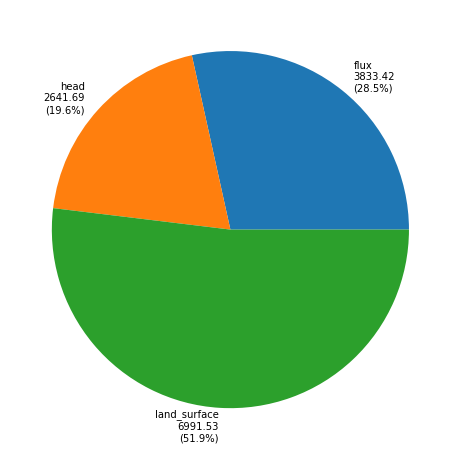

In [5]:
pst.plot(kind='phi_pie')

### we can use `pyemu` functionality to assign new weights that adjust and honor whatever balance we seek

In [6]:
new_proportions = pst.phi_components.copy()
new_proportions

{'budget': 0.0,
 'flux': 3833.4155674636218,
 'head': 2641.690715719341,
 'land_surface': 6991.534929874092}

### here we assign proportions (that sum to 1.0) to the various groups. We want to retain the same total Phi so we multiply our proportions by the total Phi

In [7]:
new_proportions['flux'] = 0.3*pst.phi
new_proportions['head'] = 0.2*pst.phi
new_proportions['land_surface'] = 0.5*pst.phi
new_proportions['budget'] = 0

In [8]:
new_proportions

{'budget': 0,
 'flux': 4039.9923639171157,
 'head': 2693.328242611411,
 'land_surface': 6733.320606528527}

### using the `phi_components` dictionary, making a copy of it, and reassigning values, we can update the PST object using the `adjust_weights` function

In [9]:
pst.adjust_weights(obsgrp_dict=new_proportions)

In [10]:
pst.observation_data

,obsnme,obsval,weight,obgnme,extra
obsnme,,,,,
q_1436500,q_1436500,116217.231560,0.001008,flux,NaN
q_1366650,q_1366650,124046.273310,0.002835,flux,NaN
h_414525074360601,h_414525074360601,357.182016,0.091539,head,NaN
h_o10577,h_o10577,203.903379,0.091539,head,NaN
h_o10942,h_o10942,150.660417,0.091539,head,NaN
...,...,...,...,...,...
land_surf_obs_550_500,land_surf_obs_550_500,365.440000,0.427371,land_surface,NaN
land_surf_obs_600_350,land_surf_obs_600_350,443.410000,0.427371,land_surface,NaN
land_surf_obs_600_400,land_surf_obs_600_400,300.950000,0.427371,land_surface,NaN


13466.641213057055 {'budget': 0.0, 'flux': 4039.992363917115, 'head': 2693.328242611411, 'land_surface': 6733.3206065285285} {'budget': 0.0, 'flux': 0.2999999999999999, 'head': 0.2, 'land_surface': 0.5000000000000001}


<AxesSubplot:>

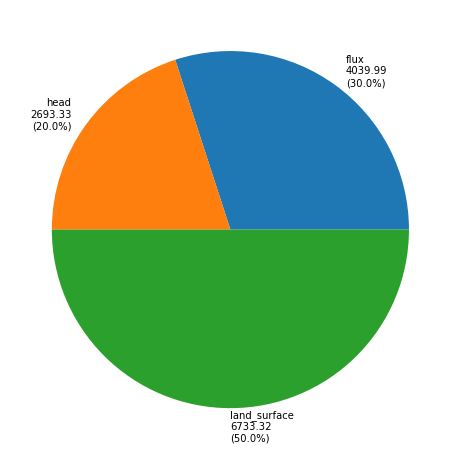

In [11]:
pst.plot(kind='phi_pie')

In [12]:
# set some values for pestpp-ies
if run_ensemble == True:
    pst.pestpp_options["ies_num_reals"] = 20  
else:
    pst.pestpp_options["ies_num_reals"] = 500 
    
pst.pestpp_options["ies_bad_phi_sigma"] = 2.5
pst.pestpp_options["overdue_giveup_fac"] = 4
pst.pestpp_options["ies_save_rescov"] = True
pst.pestpp_options["ies_no_noise"] = True
pst.pestpp_options["ies_drop_conflicts"] = False
pst.pestpp_options["ies_pdc_sigma_distance"] = 3.0
pst.pestpp_options['ies_autoadaloc']=True
pst.pestpp_options['ies_num_threads']=4
pst.pestpp_options['ies_lambda_mults']=(0.1,1.0,10.0,100.0)
pst.pestpp_options['lambda_scale_fac'] = (0.75,0.9,1.0,1.1)
pst.pestpp_options['ies_subset_size']=10

# set SVD for some regularization
pst.svd_data.maxsing = 250

In [13]:
# check number of realizations
pst.pestpp_options["ies_num_reals"]

500

### we want to use the observations in the `land_surface` group as inequality observations (e.g. unweighted unless needed to enforce "less than" condition). By naming the groups starting with "less_than" PESTPP-IES will interpret them as such

In [14]:
pst.observation_data.loc[pst.observation_data.obgnme=='land_surface', 'obgnme'] = 'less_than_land_surface' # rename for less than inequality

In [15]:
pst.observation_data

,obsnme,obsval,weight,obgnme,extra
obsnme,,,,,
q_1436500,q_1436500,116217.231560,0.001008,flux,NaN
q_1366650,q_1366650,124046.273310,0.002835,flux,NaN
h_414525074360601,h_414525074360601,357.182016,0.091539,head,NaN
h_o10577,h_o10577,203.903379,0.091539,head,NaN
h_o10942,h_o10942,150.660417,0.091539,head,NaN
...,...,...,...,...,...
land_surf_obs_550_500,land_surf_obs_550_500,365.440000,0.427371,less_than_land_surface,NaN
land_surf_obs_600_350,land_surf_obs_600_350,443.410000,0.427371,less_than_land_surface,NaN
land_surf_obs_600_400,land_surf_obs_600_400,300.950000,0.427371,less_than_land_surface,NaN


# Add standard deviation column for observations to control noise realizations

### make a "standard_deviation" column in the pst observation_data dataframe. This will inform PESTPP-IES to use these value for sampling in generating the observation noise on the ensembles. 

Start out with a value of -9999 that we can use as a test to make sure we set a value for every observation group.

In [16]:
obs = pst.observation_data
obs['standard_deviation'] = -9999

### now we set some subjective standard deviation values that we assert are more appropriate than the straight up weights.

In [17]:
obs.loc[obs.obsnme=='q_1436500'].obsval/(3.33*3)

obsnme
q_1436500    11633.356513
Name: obsval, dtype: float64

In [18]:
obs.loc[obs.obsnme=='q_1366650'].obsval/30

obsnme
q_1366650    4134.875777
Name: obsval, dtype: float64

In [19]:
obs.loc[obs.obsnme=='q_1436500', 'standard_deviation'] = obs.loc[obs.obsnme=='q_1436500'].obsval/(3.33*3)
obs.loc[obs.obsnme=='q_1366650', 'standard_deviation'] = obs.loc[obs.obsnme=='q_1366650'].obsval/(10.*3)

In [20]:
obs.loc[obs.obgnme=='head', 'standard_deviation'] =  5/3  #  5 is the range, div by 3 for the range
obs.loc[obs.obgnme=='less_than_land_surface', 'standard_deviation'] = 10/3
obs.loc[obs.obgnme=='budget', 'standard_deviation'] = 9999

### use an `assert` statment to make sure we set obs to have a standard deviation not -9999

In [21]:
assert pst.observation_data.standard_deviation.min()>0

In [22]:
pst.observation_data

,obsnme,obsval,weight,obgnme,extra,standard_deviation
obsnme,,,,,,
q_1436500,q_1436500,116217.231560,0.001008,flux,NaN,11633.356513
q_1366650,q_1366650,124046.273310,0.002835,flux,NaN,4134.875777
h_414525074360601,h_414525074360601,357.182016,0.091539,head,NaN,1.666667
h_o10577,h_o10577,203.903379,0.091539,head,NaN,1.666667
h_o10942,h_o10942,150.660417,0.091539,head,NaN,1.666667
...,...,...,...,...,...,...
land_surf_obs_550_500,land_surf_obs_550_500,365.440000,0.427371,less_than_land_surface,NaN,3.333333
land_surf_obs_600_350,land_surf_obs_600_350,443.410000,0.427371,less_than_land_surface,NaN,3.333333
land_surf_obs_600_400,land_surf_obs_600_400,300.950000,0.427371,less_than_land_surface,NaN,3.333333


### Write out an updated parameter summary XLS file

In [23]:
parsum = pst.write_par_summary_table('../report_materials/initial_iES_parsum.xlsx', report_in_linear_space=True)
parsum

,type,transform,count,initial value,lower bound,upper bound
chd,chd,fixed,176,1,1,1
k33_pp_:0,k33_pp_:0,log,202,0.934939 to 1.05467,0.76109 to 0.877788,1.16071 to 1.31726
k33_pp_:1,k33_pp_:1,log,560,0.928528 to 1.07049,0.750066 to 0.877737,1.13434 to 1.32259
k33_pp_:2,k33_pp_:2,log,473,0.905585 to 1.06095,0.74871 to 0.869043,1.13703 to 1.33378
k33_pp_:3,k33_pp_:3,log,470,0.942581 to 1.08501,0.743949 to 0.88099,1.14983 to 1.35288
k_pp_:0,k_pp_:0,log,202,0.9498 to 1.05047,0.752159 to 0.861163,1.14614 to 1.31038
k_pp_:1,k_pp_:1,log,560,0.926962 to 1.0585,0.742919 to 0.870953,1.14287 to 1.33156
k_pp_:2,k_pp_:2,log,473,0.937231 to 1.0619,0.748387 to 0.870436,1.134 to 1.34699
k_pp_:3,k_pp_:3,log,470,0.930316 to 1.05865,0.755889 to 0.854313,1.16135 to 1.32008
pp_rch__multiplier,pp_rch__multiplier,log,1,0.994781,0.955275,1.02632


### Now set `NOPTMAX=10` and write out the PEST control file. Note - to use the standard deviation column requires writing out in the new `version=2` format. In this format, the parameter and observation data sections are written to external files. This is not backward compatible with older version of PEST, but enables this new capability. Filenames for the external files will be identified in the PST file.

In [24]:
pst.control_data.noptmax = 10
pst.pestpp_options["ies_no_noise"] = False
pst.write(os.path.join(output_dir, ies_noise_obs_file), version=2)

noptmax:10, npar_adj:4911, nnz_obs:525


## If `run_ensemble=True` the cell below will run a local `never_ies_0.noise_lt_obs.pst` iES history-matching run
* simillar process as in notebooks 1.0, 1.3, and 2.0
* using the number of realizations per iteration specified by `pst.pestpp_options["ies_num_reals"]`
* will run in parallel locally using the number of cores specified below by `num_workers`
* creates a new directory called `"../master_ies/"` which is a copy of run_data 
* while running function generates worker directories that are removed when run is complete
* results moved to `"../run_data/"`

In [25]:
if run_ensemble==True:
    #  set some variables for starting a group of PEST++ workers on the local machine
    # MAKE SURE THAT PESTPP-IES and MF6 executables are in your system path or are in '../run_data'
    
    num_workers = 5  # number of local workers -- VERY IMPORTANT, DO NOT MAKE TOO BIG
    if sys.platform == 'win32':
        pst_exe = 'pestpp-ies.exe'
    else:
        pst_exe = 'pestpp-ies'
        
    template_ws =  '../run_data'  #  template_directory
    m_d = '../master_ies'
    
    pyemu.os_utils.start_workers(worker_dir=template_ws, 
                             exe_rel_path=pst_exe,
                             pst_rel_path=ies_noise_obs_file,
                             num_workers=num_workers, 
                             master_dir=m_d
                            )

In [26]:
if run_ensemble==True:
    #  move results into run_data and clean up 
    
    move_result_files = glob.glob(os.path.join(m_d, 'prior_mc_wide*'))
    move_result_files = [f for f in move_result_files if 'pst' not in f]
    
    [shutil.copy(os.path.join(m_d, file), output_dir) for file in move_result_files]
    
    #  Remove master dir.
    shutil.rmtree(m_d)